In [1]:
# Add drive and will make a copy of data to work on the same
import shutil

from google.colab import drive
drive.mount('/content/drive')

ORG_PATH="/content/drive/MyDrive/filered.csv"
NEW_PATH="/content/drive/MyDrive/filered_copy.csv"

shutil.copy(ORG_PATH, NEW_PATH)


# now reading the same

import pandas as pd


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Now we have our df as df and will use the same for the stuffs

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv(NEW_PATH, parse_dates=['Timestamp'])

print(df.info())
print(df.describe())
print("Unique stations:", df['Station'].nunique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891645 entries, 0 to 891644
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Timestamp         891645 non-null  datetime64[ns]
 1   Station           891645 non-null  int64         
 2   Station Length    891645 non-null  float64       
 3   Samples           891645 non-null  int64         
 4   % Observed        891645 non-null  float64       
 5   Total Flow        891645 non-null  float64       
 6   Avg Occupancy     891645 non-null  float64       
 7   Avg Speed         891645 non-null  float64       
 8   Lane 1 Samples    891645 non-null  float64       
 9   Lane 1 Flow       891645 non-null  float64       
 10  Lane 1 Avg Occ    891645 non-null  float64       
 11  Lane 1 Avg Speed  891645 non-null  float64       
 12  Lane 2 Samples    891645 non-null  float64       
 13  Lane 2 Flow       891645 non-null  float64       
 14  Lane

In [3]:
# Handle missing values based on % Observed

df_clean = df[df['% Observed'] > 0].copy()
df_clean = df_clean.groupby('Station').apply(lambda x: x.ffill().bfill())

print("Remaining missing values per column:")
print(df_clean.isnull().sum())


Remaining missing values per column:
Timestamp           0
Station             0
Station Length      0
Samples             0
% Observed          0
Total Flow          0
Avg Occupancy       0
Avg Speed           0
Lane 1 Samples      0
Lane 1 Flow         0
Lane 1 Avg Occ      0
Lane 1 Avg Speed    0
Lane 2 Samples      0
Lane 2 Flow         0
Lane 2 Avg Occ      0
Lane 2 Avg Speed    0
dtype: int64


<ipython-input-3-a88e4df7a24f>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('Station').apply(lambda x: x.ffill().bfill())


In [4]:
# Handling the merged values in the speed and so for 5->15 mins

def normalize_speeds(df):
    """Scale speed values by 3 and normalize"""
    for lane in ['Lane 1 Avg Speed', 'Lane 2 Avg Speed']:
        df[lane] = df[lane] / 3  # Scale down by 3
        df[f'{lane}_norm'] = df[lane] / df[lane].max()  # Normalize to [0,1]
    return df

df_clean = normalize_speeds(df_clean)

In [19]:
# Revised constraints based on lane count
LANE_COUNT = 2  # From your data - adjust accordingly
MAX_FLOW_PER_LANE = 1200  # veh/h/lane (saturation flow)

def calibrate_fundamental_diagram(df, station_id, lane_count=2):
    station_data = df[df['Station'] == station_id]
    rho = station_data['Density'].values / lane_count  # Density per lane
    q = station_data['Total Flow'].values / lane_count  # Flow per lane

    # Physical constraints
    bounds = [
        (60, 100),    # v_f (km/h)
        (20, 40),     # ρ_c (veh/km/lane)
        (-25, -15),   # w (km/h)
    ]

    # Initial guess (middle of bounds)
    initial_guess = [80, 30, -20]

    result = minimize(triangular_fd_error, initial_guess,
                     args=(rho, q), bounds=bounds)

    v_f, rho_c, w = result.x
    q_max = v_f * rho_c

    # Verify against empirical max flow
    empirical_q_max = q.max()
    if q_max > 1.2 * empirical_q_max:
        # Adjust critical density to match empirical max flow
        rho_c = empirical_q_max / v_f
        w = (q.max() - q_min) / (rho.max() - rho_c)  # q_min at max density

    return v_f, rho_c, w, q_max * lane_count  # Return total for all lanes

# Example usage
v_f, rho_c, w, q_max = calibrate_fundamental_diagram(df, 308511, LANE_COUNT)
print(f"Calibrated: v_f={v_f:.1f} km/h, ρ_c={rho_c:.1f} veh/km/lane, "
      f"w={w:.1f} km/h, q_max={q_max:.0f} veh/h (total)")

NameError: name 'q_min' is not defined

In [16]:
from scipy.optimize import minimize

def triangular_fd_error(params, rho, q):
    """Error function for constrained triangular FD fitting"""
    v_f, rho_c, w = params
    q_pred = np.where(rho <= rho_c,
                     v_f * rho,
                     v_f * rho_c + w * (rho - rho_c))
    return np.mean((q_pred - q)**2)

# Constrained optimization
initial_guess = [100, 30, -20]  # Reasonable starting values (v_f, rho_c, w)
bounds = [(80, 120), (20, 50), (-30, -10)]  # Physical constraints

# For one station's data
station_data = df[df['Station'] == 308511]
rho = station_data['Density'].values
q = station_data['Total Flow'].values

result = minimize(triangular_fd_error, initial_guess,
                 args=(rho, q), bounds=bounds)
v_f, rho_c, w = result.x
q_max = v_f * rho_c

print(f"Constrained parameters: v_f={v_f:.2f}, ρ_c={rho_c:.2f}, w={w:.2f}, q_max={q_max:.2f}")

Constrained parameters: v_f=80.00, ρ_c=30.00, w=-20.00, q_max=2400.00


In [17]:
def realistic_godunov_flux(rho_L, rho_R, v_f, rho_c, w):
    """Flux calculation with physical constraints"""
    # Ensure densities are within physical bounds
    rho_L = np.clip(rho_L, 0, 1000/VEHICLE_LENGTH)
    rho_R = np.clip(rho_R, 0, 1000/VEHICLE_LENGTH)

    # Free flow case
    if rho_L <= rho_c and rho_R <= rho_c:
        return min(v_f * rho_L, v_f * rho_R)

    # Congested case
    elif rho_L > rho_c and rho_R > rho_c:
        return v_f * rho_c + w * (min(rho_L, rho_R) - rho_c)

    # Transition cases
    elif rho_L <= rho_c:
        return min(v_f * rho_L, v_f * rho_c + w * (rho_R - rho_c))
    else:
        return min(v_f * rho_c + w * (rho_L - rho_c), v_f * rho_R)

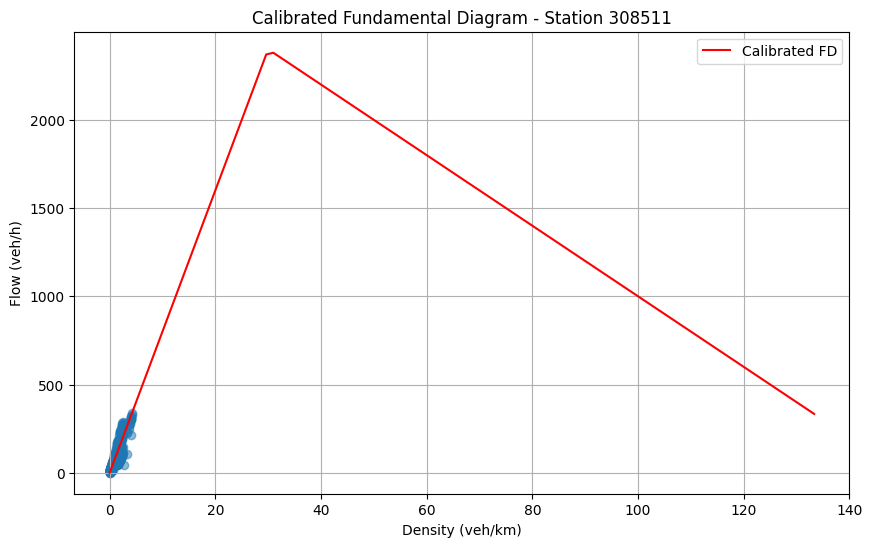

In [18]:
def plot_calibrated_fd(station_id, v_f, rho_c, w):
    station_data = df[df['Station'] == station_id]
    rho = np.linspace(0, 1000/VEHICLE_LENGTH, 100)
    q = np.where(rho <= rho_c,
                v_f * rho,
                v_f * rho_c + w * (rho - rho_c))

    plt.figure(figsize=(10,6))
    plt.scatter(station_data['Density'], station_data['Total Flow'], alpha=0.5)
    plt.plot(rho, q, 'r-', label='Calibrated FD')
    plt.xlabel('Density (veh/km)')
    plt.ylabel('Flow (veh/h)')
    plt.title(f'Calibrated Fundamental Diagram - Station {station_id}')
    plt.legend()
    plt.grid()
    plt.show()

# After calibration
plot_calibrated_fd(308511, v_f, rho_c, w)